# Temporal Fusion Transformer - Application for sub-seasonal forecasting

In [1]:
from AI_WQ_package import retrieve_training_data
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd

%load_ext autoreload
%autoreload 2

## Data preparation

In [2]:
tas_list = []
for i in range(2019,2024):
    tas_list.append(retrieve_training_data.retrieve_annual_training_data(i,'tas','NegF8LfwK',None))


File '/training_data/tas_sevenday_WEEKLYMEAN_2019.nc' has been downloaded to successfully to 'tas_sevenday_WEEKLYMEAN_2019.nc'.
File '/training_data/tas_sevenday_WEEKLYMEAN_2020.nc' has been downloaded to successfully to 'tas_sevenday_WEEKLYMEAN_2020.nc'.
File '/training_data/tas_sevenday_WEEKLYMEAN_2021.nc' has been downloaded to successfully to 'tas_sevenday_WEEKLYMEAN_2021.nc'.
File '/training_data/tas_sevenday_WEEKLYMEAN_2022.nc' has been downloaded to successfully to 'tas_sevenday_WEEKLYMEAN_2022.nc'.
File '/training_data/tas_sevenday_WEEKLYMEAN_2023.nc' has been downloaded to successfully to 'tas_sevenday_WEEKLYMEAN_2023.nc'.


In [3]:
dataframes = [ds.to_dataframe().reset_index() for ds in tas_list]
data = pd.concat(dataframes, ignore_index=True)
data

,longitude,latitude,time,tas
0,0.0,90.0,2019-01-01,247.717255
1,0.0,90.0,2019-01-02,247.099075
2,0.0,90.0,2019-01-03,245.829269
3,0.0,90.0,2019-01-04,245.053925
4,0.0,90.0,2019-01-05,244.657013
...,...,...,...,...
53027035,358.5,-90.0,2023-12-27,246.220901
53027036,358.5,-90.0,2023-12-28,246.814545
53027037,358.5,-90.0,2023-12-29,247.103027
53027038,358.5,-90.0,2023-12-30,247.178589


In [4]:
data.index = pd.to_datetime(data['time'])
data.sort_index(inplace=True)
data.replace(0., np.nan)
del data['time']
data

,longitude,latitude,tas
time,,,
2019-01-01,0.0,90.0,247.717255
2019-01-01,340.5,-66.0,272.691406
2019-01-01,177.0,-30.0,294.683868
2019-01-01,252.0,57.0,260.457092
2019-01-01,30.0,78.0,266.068695
...,...,...,...
2023-12-31,144.0,-55.5,276.989838
2023-12-31,144.0,-57.0,276.358307
2023-12-31,144.0,-58.5,275.774109


In [5]:
data['latlon'] = data['latitude'].astype('str') +'_' + data['longitude'].astype('str')
del data['latitude']
del data['longitude']

In [6]:
data

,tas,latlon
time,,
2019-01-01,247.717255,90.0_0.0
2019-01-01,272.691406,-66.0_340.5
2019-01-01,294.683868,-30.0_177.0
2019-01-01,260.457092,57.0_252.0
2019-01-01,266.068695,78.0_30.0
...,...,...
2023-12-31,276.989838,-55.5_144.0
2023-12-31,276.358307,-57.0_144.0
2023-12-31,275.774109,-58.5_144.0


Now, we prepare our dataset for the TimeSeriesDataset format. 

In [11]:
pd.DataFrame({'tas': data['tas'], 'latlon':data['latlon']})

,tas,latlon
time,,
2019-01-01,247.717255,90.0_0.0
2019-01-01,272.691406,-66.0_340.5
2019-01-01,294.683868,-30.0_177.0
2019-01-01,260.457092,57.0_252.0
2019-01-01,266.068695,78.0_30.0
...,...,...
2023-12-31,276.989838,-55.5_144.0
2023-12-31,276.358307,-57.0_144.0
2023-12-31,275.774109,-58.5_144.0


In [17]:
df_list = []
earliest_time = data.index.min()

ts = data['tas']

start_date = min(ts.fillna(method='ffill').dropna().index)
end_date = max(ts.fillna(method='bfill').dropna().index)

tmp = pd.DataFrame({'tas': data['tas']})
date = tmp.index

active_range = (ts.index >= start_date) & (ts.index <= end_date)
ts = ts[active_range].fillna(0.)
  
tmp['days_from_start'] = (date - earliest_time).days
tmp['days_from_start'] = tmp['days_from_start'].astype('int')
  
#     #tmp['days_from_start'] = (date - earliest_time).days
tmp['date'] = date
tmp['latlon'] = pd.DataFrame({'latlon':data['latlon']})
tmp['latlon'] = tmp['latlon'].astype('str')
tmp['day'] = date.day
tmp['month'] = date.month

#     #stack all time series vertically
df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)



C:\Users\Anwender\AppData\Local\Temp\ipykernel_18196\4048574375.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_18196\4048574375.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().index)


In [37]:
# # match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= (1826-5*12*30))
                & (time_df['days_from_start'] < 1826)
                & (time_df['latlon']=='57.0_252.0')].copy()

In [38]:
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting import TimeSeriesDataSet
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 30
max_encoder_length = 3*30
training_cutoff = time_df["days_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.days_from_start <= training_cutoff],
    time_idx="days_from_start",
    target="tas",
    group_ids=["latlon"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["latlon"],
    time_varying_known_reals=["days_from_start","day","month"],
    time_varying_unknown_reals=['tas'],
    #target_normalizer=GroupNormalizer(
    #    groups=["zone"], transformation="softplus"
    #),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [39]:
import torch
from pytorch_forecasting import BaseModel, MAE, Baseline

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cpu")
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

# ➢25.139617919921875

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


1.0110636949539185

In [40]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor(logging_interval='step')  
#logger = TensorBoardLogger("lightning_logs")  

trainer = Trainer(
    max_epochs=10,
    accelerator='cpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback])

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 523 K  | tr

Epoch 0: 100%|██████████| 5/5 [00:05<00:00,  0.85it/s, v_num=17, train_loss_step=3.210, val_loss=2.600, train_loss_epoch=5.550]

Metric val_loss improved. New best score: 2.604


Epoch 3:  60%|██████    | 3/5 [00:03<00:02,  0.91it/s, v_num=17, train_loss_step=2.680, val_loss=2.910, train_loss_epoch=2.520]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [33]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Anwender\Documents\GitHub\RiVaPy_development\TimeSeriesTransformer\lightning_logs\version_13\checkpoints\epoch=9-step=50.ckpt


In [34]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cpu')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

#6.067104816436768
#tensor([ 1.0064,  6.8266,  2.1732,  8.3614, 11.9679], device='cuda:0')

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2.700895071029663
tensor([2.7009])


In [35]:

#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 30, 7])


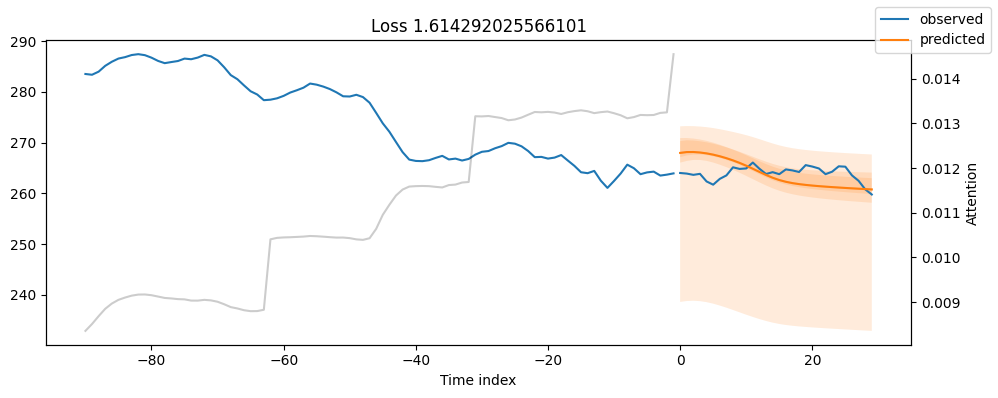

In [36]:
for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
    plt.xlabel('time step')
    #plt.ylabel('Day Ahead Price')
